# CNN FashionMNIST :)

In [3]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


## Load the [Data](https://pytorch.org/vision/stable/datasets.html)

In [4]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

In [5]:
# Data transform to convert data to a tensor and apply normalization

# augment train and validation dataset with RandomHorizontalFlip and RandomRotation
# Fixed size for all images, common for pretrained models
image_size = 224

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [6]:
# choose the training and test datasets
train_data = datasets.STL10('data', split='train',
                              download=True, transform=train_transform)
test_data = datasets.STL10('data', split='test',
                             download=True, transform=test_transform)


Files already downloaded and verified
Files already downloaded and verified


In [7]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

print(f"Total: {num_train}, Valid Size: {valid_size}, Split Index: {split}, Train Len: {len(train_idx)}, Valid Len: {len(valid_idx)}, First 10 Train Idx: {train_idx[:10]}, First 10 Valid Idx: {valid_idx[:10]}")


Total: 5000, Valid Size: 0.2, Split Index: 1000, Train Len: 4000, Valid Len: 1000, First 10 Train Idx: [1337, 1968, 1072, 859, 2450, 591, 2065, 2313, 1941, 3001], First 10 Valid Idx: [2551, 4286, 54, 496, 3573, 4509, 4931, 420, 3833, 356]


In [8]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [9]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [10]:
# specify the image classes
classes = train_data.classes
print(f"Number of classes: {len(classes)}")
print(classes)

Number of classes: 10
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


### Visualize a Batch of Training Data

In [11]:
def imshow(img_tensor):
    img = img_tensor / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [12]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
images.shape

(20, 3, 224, 224)

In [13]:
def imshow(img):
    if isinstance(img, torch.Tensor):
        img = img / 2 + 0.5  # unnormalize
        img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')


### View an Image in More Detail

In [14]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

In [ ]:
# 45 % accuracy
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # [batch, 128, 1, 1]

        self.dropout = nn.Dropout(0.25)
        self.fc = nn.Linear(128, 10)  # STL10 → 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [32, 48, 48]
        x = self.pool(F.relu(self.conv2(x)))  # [64, 24, 24]
        x = self.pool(F.relu(self.conv3(x)))  # [128, 12, 12]

        x = self.global_avg_pool(x)           # [128, 1, 1]
        x = torch.flatten(x, 1)               # [128]
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [ ]:
# 60 % accuracy
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)           # down‑sample
            )

        self.features = nn.Sequential(
            block(3,   64),   # 96 → 48
            block(64, 128),   # 48 → 24
            block(128,256),   # 24 → 12
            block(256,512),   # 12 → 6
        )

        self.global_avg = nn.AdaptiveAvgPool2d(1)  # [B, 512, 1, 1]
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.global_avg(x).flatten(1)
        return self.classifier(x)


In [16]:
# create a complete CNN
model = Net()
model

Net(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inpla

### Specify Loss Function and Optimizer


In [17]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


## Train the Network

In [18]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.077889 	Validation Loss: 1.905226
Validation loss decreased (inf --> 1.905226).  Saving model ...
Epoch: 2 	Training Loss: 1.903592 	Validation Loss: 1.880503
Validation loss decreased (1.905226 --> 1.880503).  Saving model ...
Epoch: 3 	Training Loss: 1.773347 	Validation Loss: 1.648786
Validation loss decreased (1.880503 --> 1.648786).  Saving model ...
Epoch: 4 	Training Loss: 1.686596 	Validation Loss: 1.745058
Epoch: 5 	Training Loss: 1.619666 	Validation Loss: 1.504852
Validation loss decreased (1.648786 --> 1.504852).  Saving model ...
Epoch: 6 	Training Loss: 1.548626 	Validation Loss: 1.477742
Validation loss decreased (1.504852 --> 1.477742).  Saving model ...
Epoch: 7 	Training Loss: 1.473256 	Validation Loss: 1.546131
Epoch: 8 	Training Loss: 1.443225 	Validation Loss: 1.596756
Epoch: 9 	Training Loss: 1.398348 	Validation Loss: 1.560116
Epoch: 10 	Training Loss: 1.347065 	Validation Loss: 1.642999
Epoch: 11 	Training Loss: 1.308302 	Validation Lo

###  Load the Model with the Lowest Validation Loss

In [19]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

## Test the Trained Network

In [20]:

# track test loss
test_loss = 0.0
class_correct = [0.0 for _ in range(10)]
class_total = [0.0 for _ in range(10)]

model.eval()
# iterate over test data
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item() * data.size(0)

    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())

    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.6f}\n')

for i in range(10):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print(f'Test Accuracy of {classes[i]:5s}: {accuracy:2.0f}% ({int(class_correct[i])}/{int(class_total[i])})')
    else:
        print(f'Test Accuracy of {classes[i]:5s}: N/A (no training examples)')

overall_accuracy = 100.0 * np.sum(class_correct) / np.sum(class_total)
print(f'\nTest Accuracy (Overall): {overall_accuracy:2.0f}% ({int(np.sum(class_correct))}/{int(np.sum(class_total))})')


Test Loss: 1.108239

Test Accuracy of airplane: 78% (625/800)
Test Accuracy of bird : 59% (470/800)
Test Accuracy of car  : 81% (646/800)
Test Accuracy of cat  : 43% (343/800)
Test Accuracy of deer : 28% (227/800)
Test Accuracy of dog  : 26% (204/800)
Test Accuracy of horse: 63% (502/800)
Test Accuracy of monkey: 67% (535/800)
Test Accuracy of ship : 80% (639/800)
Test Accuracy of truck: 69% (555/800)

Test Accuracy (Overall): 59% (4746/8000)


### Visualize Sample Test Results

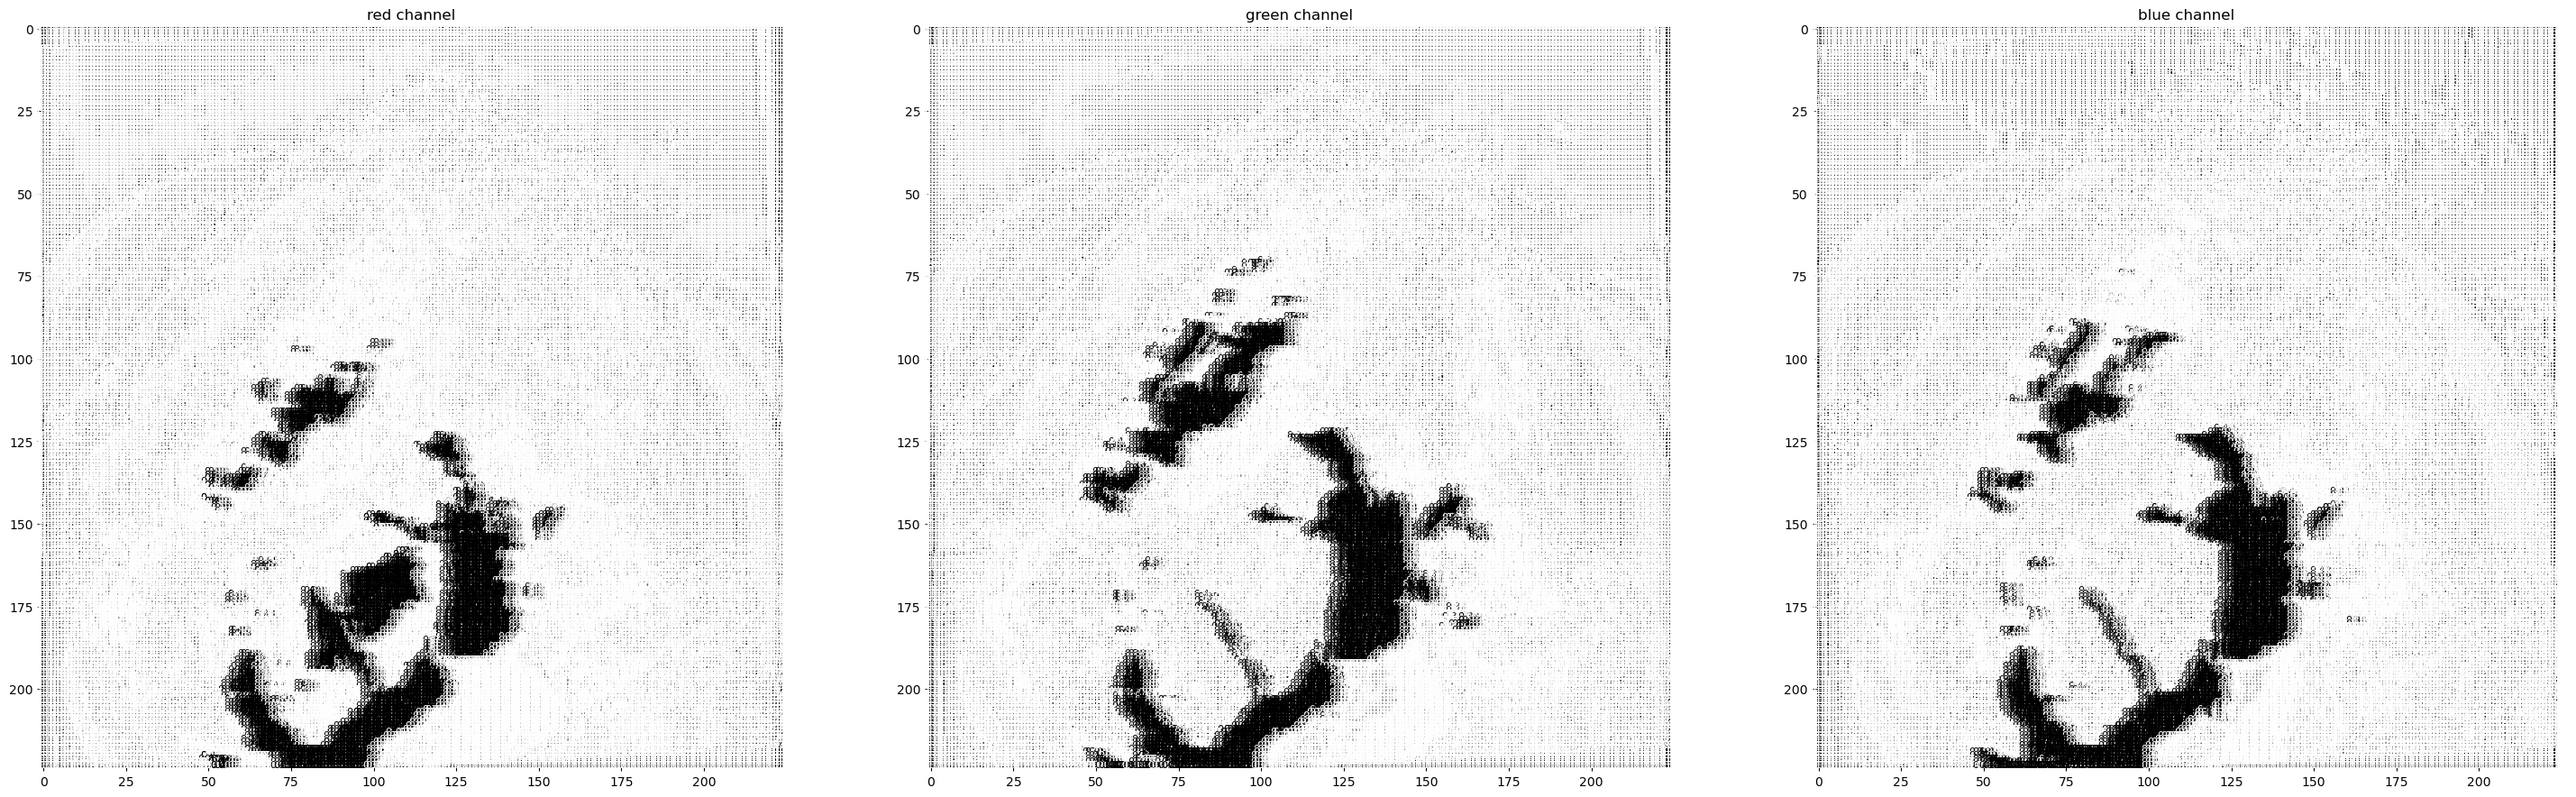

KeyboardInterrupt: 

In [71]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) 

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 // 2, idx + 1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

plt.tight_layout()
plt.show()
